In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from astropy import units as u
from astropy.coordinates import SkyCoord
import time

# MONTE CARLO CATALOG GENERATION
The following cell contains the necessary code to execute a 2 dimensional KS-test:

In [89]:
# https://github.com/syrte/ndtest; Zhaozhou Li
from __future__ import division
from numpy import random
from scipy.spatial.distance import pdist, cdist
from scipy.stats import kstwobign, pearsonr
from scipy.stats import genextreme

__all__ = ['ks2d2s', 'estat', 'estat2d']


def ks2d2s(x1, y1, x2, y2, nboot=None, extra=False):
    '''Two-dimensional Kolmogorov-Smirnov test on two samples. 
    Parameters
    ----------
    x1, y1 : ndarray, shape (n1, )
        Data of sample 1.
    x2, y2 : ndarray, shape (n2, )
        Data of sample 2. Size of two samples can be different.
    extra: bool, optional
        If True, KS statistic is also returned. Default is False.
    Returns
    -------
    p : float
        Two-tailed p-value.
    D : float, optional
        KS statistic. Returned if keyword `extra` is True.
    Notes
    -----
    This is the two-sided K-S test. Small p-values means that the two samples are significantly different. Note that the p-value is only an approximation as the analytic distribution is unkonwn. The approximation is accurate enough when N > ~20 and p-value < ~0.20 or so. When p-value > 0.20, the value may not be accurate, but it certainly implies that the two samples are not significantly different. (cf. Press 2007)
    References
    ----------
    Peacock, J.A. 1983, Two-Dimensional Goodness-of-Fit Testing in Astronomy, Monthly Notices of the Royal Astronomical Society, vol. 202, pp. 615-627
    Fasano, G. and Franceschini, A. 1987, A Multidimensional Version of the Kolmogorov-Smirnov Test, Monthly Notices of the Royal Astronomical Society, vol. 225, pp. 155-170
    Press, W.H. et al. 2007, Numerical Recipes, section 14.8
    '''
    assert (len(x1) == len(y1)) and (len(x2) == len(y2))
    n1, n2 = len(x1), len(x2)
    D = avgmaxdist(x1, y1, x2, y2)

    if nboot is None:
        sqen = np.sqrt(n1 * n2 / (n1 + n2))
        r1 = pearsonr(x1, y1)[0]
        r2 = pearsonr(x2, y2)[0]
        r = np.sqrt(1 - 0.5 * (r1**2 + r2**2))
        d = D * sqen / (1 + r * (0.25 - 0.75 / sqen))
        p = kstwobign.sf(d)
    else:
        n = n1 + n2
        x = np.concatenate([x1, x2])
        y = np.concatenate([y1, y2])
        d = np.empty(nboot, 'f')
        for i in range(nboot):
            idx = random.choice(n, n, replace=True)
            ix1, ix2 = idx[:n1], idx[n1:]
            #ix1 = random.choice(n, n1, replace=True)
            #ix2 = random.choice(n, n2, replace=True)
            d[i] = avgmaxdist(x[ix1], y[ix1], x[ix2], y[ix2])
        p = np.sum(d > D).astype('f') / nboot
    if extra:
        return p, D
    else:
        return p


def avgmaxdist(x1, y1, x2, y2):
    D1 = maxdist(x1, y1, x2, y2)
    D2 = maxdist(x2, y2, x1, y1)
    return (D1 + D2) / 2


def maxdist(x1, y1, x2, y2):
    n1 = len(x1)
    D1 = np.empty((n1, 4))
    for i in range(n1):
        a1, b1, c1, d1 = quadct(x1[i], y1[i], x1, y1)
        a2, b2, c2, d2 = quadct(x1[i], y1[i], x2, y2)
        D1[i] = [a1 - a2, b1 - b2, c1 - c2, d1 - d2]

    # re-assign the point to maximize difference,
    # the discrepancy is significant for N < ~50
    D1[:, 0] -= 1 / n1

    dmin, dmax = -D1.min(), D1.max() + 1 / n1
    return max(dmin, dmax)


def quadct(x, y, xx, yy):
    n = len(xx)
    ix1, ix2 = xx <= x, yy <= y
    a = np.sum(ix1 & ix2) / n
    b = np.sum(ix1 & ~ix2) / n
    c = np.sum(~ix1 & ix2) / n
    d = 1 - a - b - c
    return a, b, c, d


def estat2d(x1, y1, x2, y2, **kwds):
    return estat(np.c_[x1, y1], np.c_[x2, y2], **kwds)


def estat(x, y, nboot=1000, replace=False, method='log', fitting=False):
    '''
    Energy distance statistics test.
    Reference
    ---------
    Aslan, B, Zech, G (2005) Statistical energy as a tool for binning-free
      multivariate goodness-of-fit tests, two-sample comparison and unfolding.
      Nuc Instr and Meth in Phys Res A 537: 626-636
    Szekely, G, Rizzo, M (2014) Energy statistics: A class of statistics
      based on distances. J Stat Planning & Infer 143: 1249-1272
    Brian Lau, multdist, https://github.com/brian-lau/multdist
    '''
    n, N = len(x), len(x) + len(y)
    stack = np.vstack([x, y])
    stack = (stack - stack.mean(0)) / stack.std(0)
    if replace:
        rand = lambda x: random.randint(x, size=x)
    else:
        rand = random.permutation

    en = energy(stack[:n], stack[n:], method)
    en_boot = np.zeros(nboot, 'f')
    for i in range(nboot):
        idx = rand(N)
        en_boot[i] = energy(stack[idx[:n]], stack[idx[n:]], method)

    if fitting:
        param = genextreme.fit(en_boot)
        p = genextreme.sf(en, *param)
        return p, en, param
    else:
        p = (en_boot >= en).sum() / nboot
        return p, en, en_boot


def energy(x, y, method='log'):
    dx, dy, dxy = pdist(x), pdist(y), cdist(x, y)
    n, m = len(x), len(y)
    if method == 'log':
        dx, dy, dxy = np.log(dx), np.log(dy), np.log(dxy)
    elif method == 'gaussian':
        raise NotImplementedError
    elif method == 'linear':
        pass
    else:
        raise ValueError
    z = dxy.sum() / (n * m) - dx.sum() / n**2 - dy.sum() / m**2
    # z = ((n*m)/(n+m)) * z # ref. SR
    return z

Now read in the blazar catalog data:

In [3]:
df = pd.read_csv("/mnt/c/Users/joerg/OneDrive/Dokumente/UNI/Bachelor of Science/Bachelorarbeit/Jupyter Notebook/blazar_clean.csv")
del df["Unnamed: 0"], df["SOURCE_NUMBER"], df["NAME"], df["REDSHIFT"], df["REDSHIFT_FLAG"], df["FLUX_1P4_GHZ"], df["RMAG"], df["XRAY_FLUX"], df["OBJECT_TYPE"], df["FLUX_143_GHZ"], df["GR_PHOTON_FLUX"], df["RO_SPECTRAL_INDEX"], df["l"], df["b"]
df

,RA,DEC
0,186.861167,-44.610639
1,181.245458,-50.932389
2,169.612292,-46.570828
3,195.917792,-46.350639
4,216.295708,-46.081639
...,...,...
1172,297.947750,-5.162219
1173,304.740667,-5.158169
1174,313.847417,-5.105358
1175,40.233958,-5.078328


## MC catalog generation algorithm:
Stored in a dictionary (called a), wherein every entry contains a different newly generated catalog

In [94]:
a={}
for i in range(10): # Put the number of catalogs to be generated into this range()-function
    t0 = time.time()
    a[i] = (np.array([z+random.uniform(-10, 10) for z in df["RA"].tolist()]), np.array([z+random.uniform(-5, 5) for z in df["DEC"].tolist()]))
    a_gal = SkyCoord(ra=a[i][0]*u.degree, dec=a[i][1]*u.degree, frame="icrs").galactic
    for j in range(1177):
###############################################################
    # This section does not work correctly yet. Doesn't shift values along b-axis.
        if 0 < a_gal.b.value[j] < 10:
            a[i][1][j] = SkyCoord(l = a_gal.l.value[j]*u.degree, b = (a_gal.b.value[j] + 10)*u.degree, frame="galactic").icrs.dec.value
        if -10 < a_gal.b.value[j] < 0:
            a[i][1][j] = SkyCoord(l = a_gal.l.value[j]*u.degree, b = (a_gal.b.value[j] - 10)*u.degree, frame="galactic").icrs.dec.value
###############################################################
        if a[i][1][j] > -5:
            a[i][1][j] = a[i][1][j] - 5
        if a[i][1][j] < -85:
            a[i][1][j] = a[i][1][j] + 5
        if a[i][1][j] > -5:
            a[i][1][j] = a[i][1][j] - 5
        if a[i][0][j] > 360:
            a[i][0][j] = a[i][0][j] - 10
        if a[i][0][j] < 0:
            a[i][0][j] = a[i][0][j] + 10
    print(f'kstest result: {ks2d2s(df.to_numpy()[:,0], df.to_numpy()[:,1], a[i][0], a[i][1]):.4f}    euclidean distance: {np.linalg.norm(np.array((df.to_numpy()[0,0], df.to_numpy()[0,1])) - np.array((a[i][0][0], a[i][1][0]))):.2f}    distance (RA): {np.linalg.norm(df.to_numpy()[0,0] - a[i][0][0]):.2f}    distance (DEC): {np.linalg.norm(df.to_numpy()[0,1] - a[i][1][0]):.2f}')
    t1 = time.time()
    print(f"The MC catalog generation took: {t1-t0:.3f}s")

kstest result: 0.6090    euclidean distance: 9.08    distance (RA): 9.08    distance (DEC): 0.04
The MC catalog generation took: 0.528s
kstest result: 0.7639    euclidean distance: 4.52    distance (RA): 4.45    distance (DEC): 0.78
The MC catalog generation took: 0.575s
kstest result: 0.7225    euclidean distance: 9.05    distance (RA): 7.91    distance (DEC): 4.39
The MC catalog generation took: 0.577s
kstest result: 0.8287    euclidean distance: 9.98    distance (RA): 9.97    distance (DEC): 0.55
The MC catalog generation took: 0.576s
kstest result: 0.8640    euclidean distance: 10.03    distance (RA): 9.27    distance (DEC): 3.84
The MC catalog generation took: 0.508s
kstest result: 0.9591    euclidean distance: 10.25    distance (RA): 9.33    distance (DEC): 4.26
The MC catalog generation took: 0.495s
kstest result: 0.9054    euclidean distance: 7.72    distance (RA): 7.18    distance (DEC): 2.85
The MC catalog generation took: 0.523s
kstest result: 0.9698    euclidean distance: 4

Plot one of the generated catalogs:

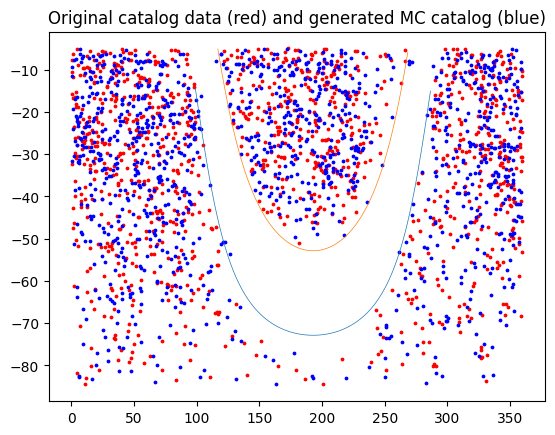

In [105]:
plt.scatter(df["RA"], df["DEC"], s=3, c="r")
plt.scatter(a[5][0], a[5][1], s=3, c="b")
plt.title("Original catalog data (red) and generated MC catalog (blue)")
#plt.savefig("/mnt/c/Users/joerg/OneDrive/Dokumente/UNI/Bachelor of Science/Bachelorarbeit/Jupyter Notebook/Figures/MC_test.png", dpi=700)

l_interval = np.linspace(0, 360, 360) - np.linspace(136, 339, 360)
galactic_plane_upper = SkyCoord(l=l_interval*u.degree, b=-10*u.degree, frame='galactic')
galactic_plane_lower = SkyCoord(l=l_interval*u.degree, b=10*u.degree, frame='galactic')
gp1 = plt.plot(galactic_plane_upper.icrs.ra, galactic_plane_upper.icrs.dec, linewidth=0.5, label="galactic plane1")
gp2 = plt.plot(galactic_plane_lower.icrs.ra, galactic_plane_lower.icrs.dec, linewidth=0.5, label="galactic plane2")